# Notebook TITANIC
<br>

Notebook Python Azure ML service pour la modélisation automatique (AUTOML) de la survie des passagers du Titanic.


<img src="https://kwmp.ca/wp-content/uploads/2018/04/titanic-the-musical-1024x538.jpg">

 ## Description des variables :
 - PassengerId: and id given to each traveler on the boat
 - Pclass: the passenger class. It has three possible values: 1,2,3 (first, second and third class)
 - The Name of the passeger
 - The Sex
 - The Age
 - SibSp: number of siblings and spouses traveling with the passenger
 - Parch: number of parents and children traveling with the passenger
 - The ticket number
 - The ticket Fare
 - The cabin number
 - The embarkation. This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q

> Plus d'information sur les données : https://www.kaggle.com/c/titanic

## Utilisation Azure ML service :

> Documentation : https://azure.microsoft.com/en-us/services/machine-learning-service/
<br>

### 0. Paramétrage

In [1]:
# Version python 3.6
import sys
sys.version

'3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) \n[GCC 7.2.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2019-10-22 09:07:51.372208


In [3]:
import azureml.core
print("Version Azure ML Service :", azureml.core.VERSION)

Version Azure ML Service : 1.0.57


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.io.sql as pd_sql

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
# Installation SEABORN pour les graphiques
#!pip install seaborn
import seaborn as sns

## 1. Chargement des données

In [6]:
url="https://raw.githubusercontent.com/retkowsky/titanic/master/train.csv"
train=pd.read_csv(url, index_col=None, na_values=['NA'])

# Suppression valeurs manquantes
train = train.dropna()

In [7]:
# Nombre de col et de lignes
print(train.shape)

(183, 12)


In [8]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 12 columns):
PassengerId    183 non-null int64
Survived       183 non-null int64
Pclass         183 non-null int64
Name           183 non-null object
Sex            183 non-null object
Age            183 non-null float64
SibSp          183 non-null int64
Parch          183 non-null int64
Ticket         183 non-null object
Fare           183 non-null float64
Cabin          183 non-null object
Embarked       183 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


In [10]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.70,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,113783,26.55,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.00,0,0,248698,13.00,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.00,0,0,113788,35.50,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.00,C23 C25 C27,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.00,1,0,PC 17572,76.73,D33,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.00,0,1,113509,61.98,B30,C


In [11]:
# Suppression de colonnes
train = train.drop(['Cabin','Parch'],axis=1)

In [12]:
train.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,PC 17599,71.28,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,113803,53.10,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,17463,51.86,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,PP 9549,16.70,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,113783,26.55,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.00,0,248698,13.00,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.00,0,113788,35.50,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,19950,263.00,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.00,1,PC 17572,76.73,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.00,0,113509,61.98,C


## 2. Analyses exploratoires

In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
count,183.00,183.00,183.00,183.00,183.00,183.00
mean,455.37,0.67,1.19,35.67,0.46,78.68
std,247.05,0.47,0.52,15.64,0.64,76.35
min,2.00,0.00,1.00,0.92,0.00,0.00
25%,263.50,0.00,1.00,24.00,0.00,29.70
50%,457.00,1.00,1.00,36.00,0.00,57.00
75%,676.00,1.00,1.00,47.50,1.00,90.00
max,890.00,1.00,3.00,80.00,3.00,512.33


In [14]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
PassengerId,1.00,0.15,-0.09,0.03,-0.08,0.03
Survived,0.15,1.00,-0.03,-0.25,0.11,0.13
Pclass,-0.09,-0.03,1.00,-0.31,-0.10,-0.32
Age,0.03,-0.25,-0.31,1.00,-0.16,-0.09
SibSp,-0.08,0.11,-0.10,-0.16,1.00,0.29
Fare,0.03,0.13,-0.32,-0.09,0.29,1.00


### Distribution variable Cible

Text(0.5, 1.0, 'Survie (1 = Survie, 0 = Décès)')

<Figure size 432x288 with 0 Axes>

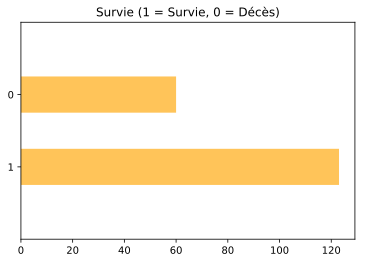

In [15]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
train.Survived.value_counts().plot(kind='barh', color="orange", alpha=.65)
ax.set_ylim(-1, len(train.Survived.value_counts())) 
plt.title("Survie (1 = Survie, 0 = Décès)")

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


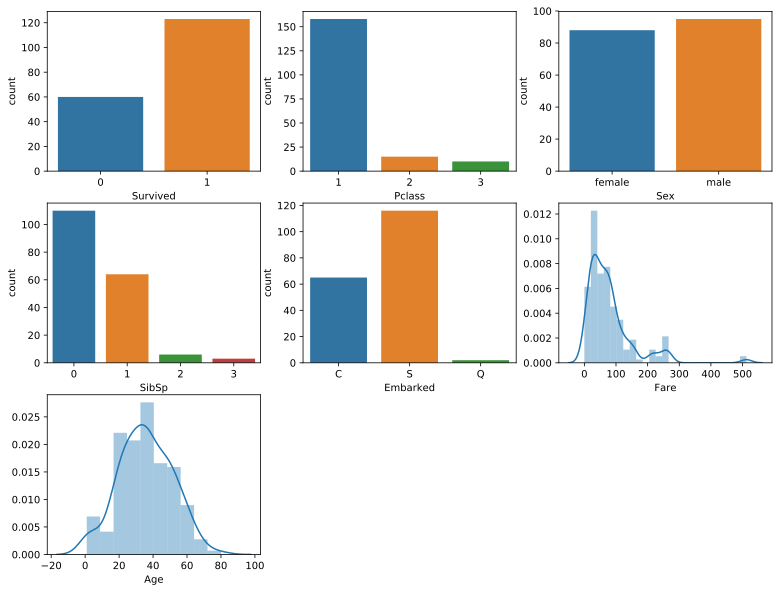

In [16]:
categ =  [ 'Survived', 'Pclass', 'Sex', 'SibSp', 'Embarked']
conti = ['Fare', 'Age']

fig = plt.figure(figsize=(13, 10))
for i in range (0,len(categ)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=categ[i], data=train);  

for col in conti:
    fig.add_subplot(3,3,i + 2)
    sns.distplot(train[col].dropna());
    i += 1
    
plt.show()
fig.clear()

## Tables Pivot

In [17]:
# Répartition par Sexe
train.groupby('Sex')[['Survived']].mean()

,Survived
Sex,
female,0.93
male,0.43


In [18]:
# Répartition par Classe
train.pivot_table('Survived', index='Sex', columns='Pclass')

Pclass,1,2,3
Sex,,,
female,0.96,0.89,0.60
male,0.42,0.67,0.40


In [19]:
Age = pd.cut(train['Age'], [0, 18, 80])
train.pivot_table('Survived', ['Sex', Age], 'Pclass')

Pclass             1    2    3
Sex    Age                    
female (0, 18]  0.91 1.00 0.50
       (18, 80] 0.97 0.88 0.67
male   (0, 18]  0.80 1.00 1.00
       (18, 80] 0.39 0.33 0.25

In [20]:
train.pivot_table('Survived', ['SibSp', Age], 'Pclass')

Pclass            1    2    3
SibSp Age                    
0     (0, 18]  1.00  nan 0.50
      (18, 80] 0.60 0.73 0.50
1     (0, 18]  0.75 1.00 1.00
      (18, 80] 0.73  nan 0.00
2     (0, 18]  1.00 1.00  nan
      (18, 80] 0.67  nan  nan
3     (18, 80] 0.67  nan  nan

### Distribution variable pclass

In [21]:
train.pivot_table('Survived', index='Pclass')

,Survived
Pclass,
1,0.67
2,0.80
3,0.50


In [22]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
1,2,0.80
0,1,0.67
2,3,0.50


### Distribution variable sexe

In [23]:
train.pivot_table('Survived', index='Sex')

,Survived
Sex,
female,0.93
male,0.43


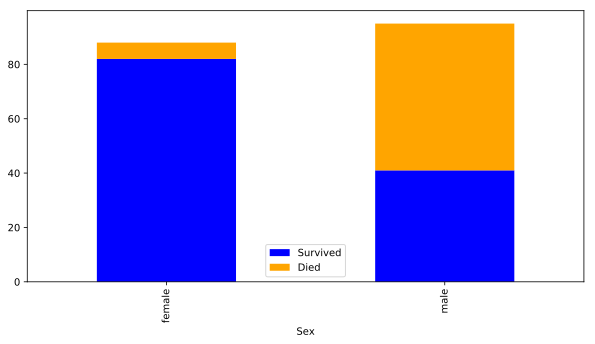

In [24]:
train['Died'] = 1 - train['Survived']
train.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(10, 5),
                                                          stacked=True, color=['b', 'orange']);

### Distribution variable Sexe en %

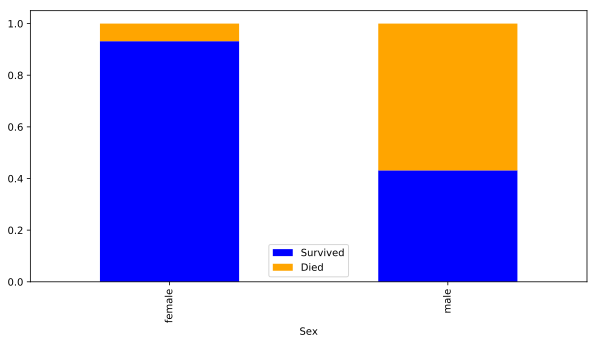

In [25]:
train.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(10, 5), 
                                                           stacked=True, color=['b', 'orange']);

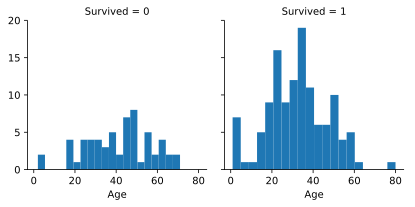

In [26]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


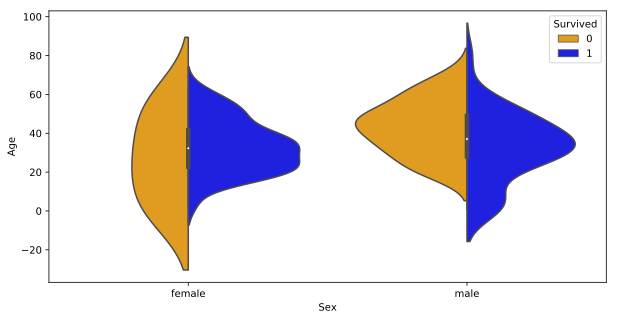

In [27]:
fig = plt.figure(figsize=(10, 5))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=train, 
               split=True,
               palette={0: "orange", 1: "b"}
              );

### Analyse de l'influence du prix

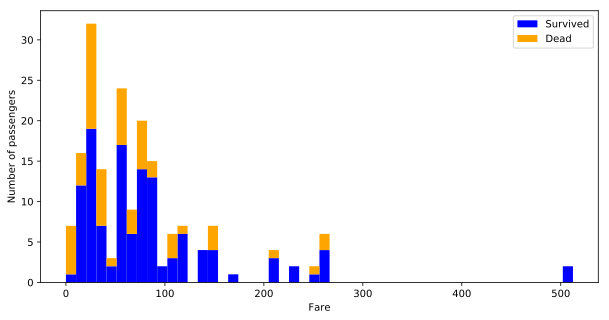

In [28]:
figure = plt.figure(figsize=(10, 5))
plt.hist([train[train['Survived'] == 1]['Fare'], train[train['Survived'] == 0]['Fare']], 
         stacked=True, color = ['b','orange'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

### Analyse de la cible


Number of survivors and non-survivors : 
 1    123
0     60
Name: Survived, dtype: int64

Percentage of survivors and non-survivors : 
 1   67.21
0   32.79
Name: Survived, dtype: float64


Text(0.5, 1.0, 'Distribution of Survival, (1 = Survived)')

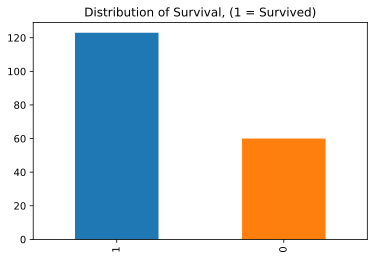

In [29]:
print("\nNumber of survivors and non-survivors : \n",train['Survived'].value_counts())
print("\nPercentage of survivors and non-survivors : \n",train['Survived'].value_counts() * 100 / len(train))

alpha_color = 0.7
train['Survived'].value_counts().plot(kind='bar')
plt.title("Distribution of Survival, (1 = Survived)")


Min age = 0.92
Max age = 80.0


Text(0.5, 1.0, 'Survival by Age,  (1 = Survived)')

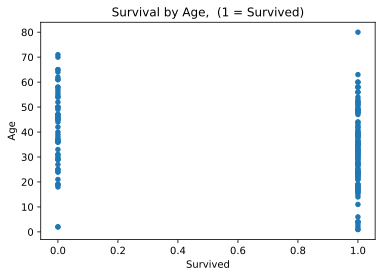

In [30]:
print("\nMin age =",train['Age'].min())
print("Max age =",train['Age'].max())

train.plot(kind='scatter',x='Survived',y='Age')
plt.title("Survival by Age,  (1 = Survived)")

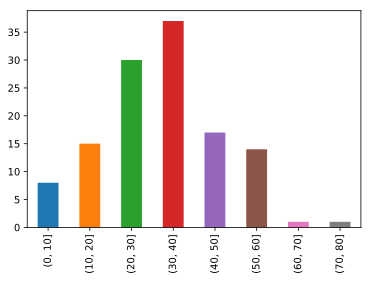

In [31]:
#Let's display the graph showing number of survivors in each age groups
b = [0, 10, 20, 30, 40, 50, 60, 70, 80,]
train['AgeBin'] = pd.cut(train['Age'],b)
train[train['Survived'] == 1]['AgeBin'].value_counts().sort_index().plot(kind='bar')

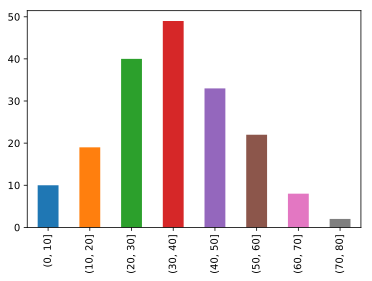

In [32]:
train['AgeBin'].value_counts().sort_index().plot(kind='bar')



Number of passengers in each classes: 
 1    158
2     15
3     10
Name: Pclass, dtype: int64


,PassengerId,Survived,Age,SibSp,Fare,Died
Pclass,,,,,,
1,467.22,0.67,37.59,0.49,88.68,0.33
2,343.27,0.80,25.27,0.40,18.44,0.20
3,436.20,0.50,21.00,0.20,11.03,0.50


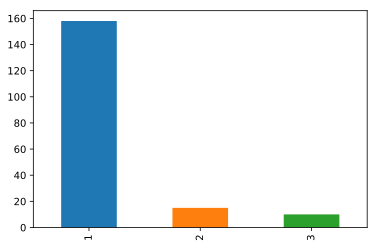

In [33]:
print("\n\nNumber of passengers in each classes: \n",train['Pclass'].value_counts())
train['Pclass'].value_counts().sort_index().plot(kind='bar')
train.groupby('Pclass').mean()

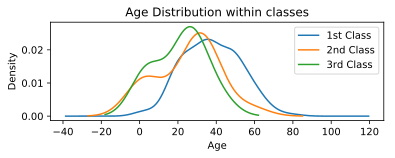

In [34]:
plt.subplot2grid((2,2),(0,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
 # plots antitanic axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')

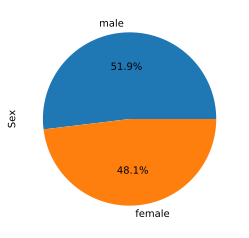

In [35]:
train['Sex'].value_counts().plot(kind='pie',autopct='%1.01f%%')

In [36]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.93
1,male,0.43


In [37]:
genderclass = train.groupby(['Pclass','Sex']).mean()
genderclass

PassengerId  Survived   Age  SibSp   Fare  Died
Pclass Sex                                                    
1      female       472.78      0.96 34.09   0.58 103.13  0.04
       male         462.32      0.42 40.67   0.40  75.96  0.58
2      female       440.67      0.89 29.61   0.22  14.87  0.11
       male         197.17      0.67 18.75   0.67  23.81  0.33
3      female       337.60      0.60 17.20   0.40  13.36  0.40
       male         534.80      0.40 24.80   0.00   8.70  0.60

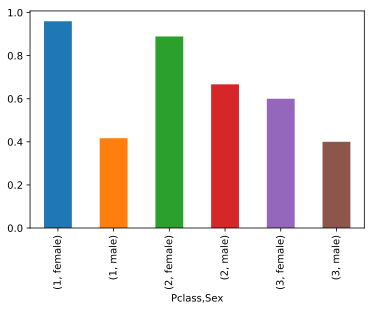

In [38]:
genderclass['Survived'].plot.bar()

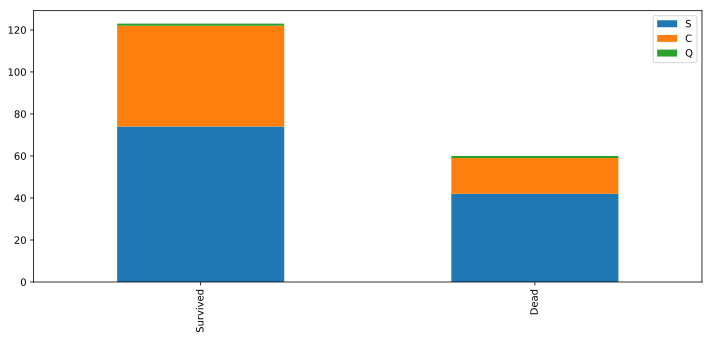

In [39]:
survived_embark = train[train['Survived']==1]['Embarked'].value_counts()
dead_embark = train[train['Survived']==0]['Embarked'].value_counts()
df = pd.DataFrame([survived_embark,dead_embark])
df.index = ['Survived','Dead']
df.plot(kind='bar', stacked=True, figsize=(12,5))

In [40]:
col_target=['Survived']
col_train=['Age','Pclass','Sex','Fare','SibSp']
X=train[col_train]
y=train[col_target]

## 3. Modélisation AutoML avec Azure ML service

<img src="https://blog.cellenza.com/wp-content/uploads/2018/11/automl.png">

In [42]:
X.describe()

,Age,Pclass,Fare,SibSp
count,183.00,183.00,183.00,183.00
mean,35.67,1.19,78.68,0.46
std,15.64,0.52,76.35,0.64
min,0.92,1.00,0.00,0.00
25%,24.00,1.00,29.70,0.00
50%,36.00,1.00,57.00,0.00
75%,47.50,1.00,90.00,1.00
max,80.00,3.00,512.33,3.00


In [43]:
dic = {'male':0,'female':1}
X['Sex']=X['Sex'].apply(lambda x:dic[x])

In [44]:
X.head()

,Age,Pclass,Sex,Fare,SibSp
1,38.00,1,1,71.28,1
3,35.00,1,1,53.10,1
6,54.00,1,0,51.86,0
10,4.00,3,1,16.70,1
11,58.00,1,1,26.55,0


### 3.1 Partitionnement des données

In [45]:
testsize=0.3

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=testsize, random_state=10)

In [46]:
print(X.shape)

(183, 5)


In [47]:
print(X_train.shape)

(128, 5)


In [48]:
print(X_test.shape)

(55, 5)


### 3.2 Connexion workspace Azure ML service

In [49]:
ws = Workspace.from_config()

experiment_name = 'workshoptitanic'
project_folder = './sample_projects/titanic'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FSTMHRCP4 to authenticate.
Interactive authentication successfully completed.


,
SDK version,1.0.57
Workspace Name,azuremlservice
Resource Group,azuremlserviceresourcegroup
Location,westeurope
Project Directory,./sample_projects/titanic
Experiment Name,workshoptitanic


### 3.3 AutoML avec Azure ML service

### Les principes de l'autoML


<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-automated-ml/automated-machine-learning.png">

> https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

### Aide en ligne AutoML avec Azure ML service

> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train

### Paramétrage AutoML

In [76]:
automl_settings = {
    "iteration_timeout_minutes" : 10,
    "iterations" : 10,
    "primary_metric" : 'AUC_weighted',
    "verbosity" : logging.INFO,
    "n_cross_validations": 3
}

In [77]:
from azureml.train.automl import AutoMLConfig

automated_ml_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             preprocess=True,
                             X = X_train.values,
                             y = y_train.values.flatten(),
                             **automl_settings)

### Exécution autoML

In [78]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(automated_ml_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_145e5844-b22f-4ad6-8cb6-58304b78be4b
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS SUMMARY:
For more details, use API: run.get_guardrails()

TYPE:         Missing Values Imputation
STATUS:       FIXED
DESCRIPTION:  The training data had the following missing values which were resolved.

Please review your data source for data quality issues and possibly filter out the rows with these missing values.

If the missing values are expected, you can either accept the above imputation, or implement

### Visualisation des itérations depuis le portail Azure :

In [79]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
workshoptitanic,AutoML_145e5844-b22f-4ad6-8cb6-58304b78be4b,automl,Running,Link to Azure Portal,Link to Documentation


### Widget AutoML

In [80]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 3.4 Liste des résultats autoML

In [81]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,0.81,0.81,0.79,0.81,0.81,0.79,0.81,0.81,0.84,0.83
AUC_micro,0.81,0.81,0.79,0.81,0.81,0.79,0.81,0.81,0.84,0.83
AUC_weighted,0.81,0.81,0.79,0.81,0.81,0.79,0.81,0.81,0.84,0.83
accuracy,0.73,0.70,0.71,0.74,0.73,0.70,0.73,0.71,0.73,0.71
average_precision_score_macro,0.89,0.89,0.90,0.89,0.90,0.88,0.89,0.90,0.92,0.92
average_precision_score_micro,0.89,0.89,0.90,0.89,0.90,0.88,0.89,0.90,0.92,0.92
average_precision_score_weighted,0.89,0.89,0.90,0.89,0.90,0.88,0.89,0.90,0.92,0.92
balanced_accuracy,0.75,0.71,0.71,0.77,0.72,0.71,0.75,0.73,0.74,0.56
f1_score_macro,0.71,0.67,0.69,0.73,0.71,0.67,0.72,0.70,0.71,0.50
f1_score_micro,0.73,0.70,0.71,0.74,0.73,0.70,0.73,0.71,0.73,0.71


### 3.5 Choix du meilleur modèle selon l'AUC

In [82]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon l'AUC :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon l'AUC :

Run(Experiment: workshoptitanic,
Id: AutoML_145e5844-b22f-4ad6-8cb6-58304b78be4b_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('3...2222222222222222, 0.1111111111111111, 0.4444444444444444, 0.1111111111111111, 0.1111111111111111]))])


In [83]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('3...2222222222222222, 0.1111111111111111, 0.4444444444444444, 0.1111111111111111, 0.1111111111111111]))])>

In [84]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
          is_onnx_compatible=None, logger=None, observer=None, task=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                 estimators=[('3', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fe6f4b86e10>), ('sgdclassifierwrapper', SGDClassifierWrapper(alpha=0.0001, class_weight='balanced', eta0=0.0001,
             fit_intercept=False, ...
             penalty='none', power_t=0.1111111111111111, random_state=None,
             tol=0.01))]))],
                 flatten_transform=None,
                 weights=[0.2222222222222222, 0.1111111111111111, 0.4444444444444444, 0.1111111111111111, 0.1111111111111111]))]

### 3.6 Changement métrique de qualité (On utilise maintenant le F1)
##### F1=2*(Precision X Recall)/(Precision+Recall)
> https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [85]:
lookup_metric = "f1_score_weighted"

best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print("Meilleur modèle selon F1:")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon F1:

Run(Experiment: workshoptitanic,
Id: AutoML_145e5844-b22f-4ad6-8cb6-58304b78be4b_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fe6f47b49e8>), ('SG...       n_jobs=1, penalty='l2', power_t=0.2222222222222222,
           random_state=None, tol=0.01))])


### 3.7 Choix d'une itération particulière

In [86]:
# choix itération
iteration = 5

my_run, my_model = local_run.get_output(iteration = iteration)

print("Modèle "+ str(iteration) +"ème itération :")
print("")
print(my_run)
print("")
print(my_model)

Modèle 5ème itération :

Run(Experiment: workshoptitanic,
Id: AutoML_145e5844-b22f-4ad6-8cb6-58304b78be4b_5,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7fe6f4ef8a90>), ('Li..., subsample=0.3963157894736842,
          subsample_for_bin=200000, subsample_freq=0, verbose=-10))])


### 4. On applique le modèle sur la base de Test

### 4.1 On utilise le meilleur modèle selon l'AUC

In [87]:
best_run, fitted_model = local_run.get_output()

print("Meilleur modèle selon l'AUC :")
print("")
print(best_run)
print("")
print(fitted_model)

Meilleur modèle selon l'AUC :

Run(Experiment: workshoptitanic,
Id: AutoML_145e5844-b22f-4ad6-8cb6-58304b78be4b_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('3...2222222222222222, 0.1111111111111111, 0.4444444444444444, 0.1111111111111111, 0.1111111111111111]))])


### 4.2 On applique le modèle

In [88]:
# Calcul de la décision
y_test_pred = fitted_model.predict(X_test.values)

In [89]:
Decision=pd.DataFrame(y_test_pred)

In [90]:
# Obtention des scores
proba=fitted_model.predict_proba(X_test.values)

In [91]:
Decision.columns = ['Decision']
Decision.head()

,Decision
0,1
1,1
2,0
3,1
4,1


In [92]:
Proba=pd.DataFrame(proba)

In [93]:
Proba.columns = ['Proba_0', 'Proba_1']

In [94]:
Proba.head()

,Proba_0,Proba_1
0,0.23,0.77
1,0.23,0.77
2,0.54,0.46
3,0.23,0.77
4,0.24,0.76


In [95]:
Scoring = pd.concat([Decision, Proba], axis=1)

### 4.3 Résultats du scoring

In [96]:
Scoring.head()

,Decision,Proba_0,Proba_1
0,1,0.23,0.77
1,1,0.23,0.77
2,0,0.54,0.46
3,1,0.23,0.77
4,1,0.24,0.76


In [97]:
Scoring.dtypes

Decision    int64  
Proba_0     float64
Proba_1     float64
dtype: object

In [98]:
Scoring.describe()

,Decision,Proba_0,Proba_1
count,55.00,55.00,55.00
mean,0.87,0.37,0.63
std,0.34,0.12,0.12
min,0.00,0.19,0.45
25%,1.00,0.23,0.54
50%,1.00,0.42,0.58
75%,1.00,0.46,0.77
max,1.00,0.55,0.81


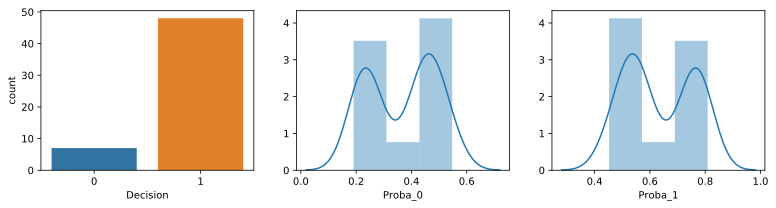

In [99]:
# Distributions

categ =  [ 'Decision']
conti = ['Proba_0', 'Proba_1']

#Distribution
fig = plt.figure(figsize=(13, 10))
for i in range (0,len(categ)):
    fig.add_subplot(3,3,i+1)
    sns.countplot(x=categ[i], data=Scoring);  

for col in conti:
    fig.add_subplot(3,3,i + 2)
    sns.distplot(Scoring[col].dropna());
    i += 1
    
plt.show()
fig.clear()

### 4.4 Exportation des scores dans un fichier CSV

In [100]:
# Export CSV
Scoring.to_csv(r'outputs/Titanic_scoring.csv')

In [101]:
%ls outputs/Titanic*.csv -l

-rw-r--r-- 1 nbuser nbuser 2406 Oct 22 09:43 outputs/Titanic_scoring.csv


> Fin